<a href="https://colab.research.google.com/github/Kuroishin-beep/DataLab/blob/main/Copy_of_Group_4_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification from scratch

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Edited by:** Group 4<br>
**Description:** Training an image classifier from scratch on the new polymer PHP 1000 and random images (other denominations & random objects) dataset.

## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.

## Setup

In [ ]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0

## Load the data: the Cats vs Dogs dataset

### Raw data download

First, let's download the 786M ZIP archive of the raw data:

In [ ]:
!pip install gdown  # Install gdown
import gdown

# File ID from the Google Drive link
file_id = '1z7RP2Gm29a2-InMdvaBo6OnZvBjSeMEV'
url = f'https://drive.google.com/uc?export=download&id={file_id}'

# Download the file
gdown.download(url, 'images_5k.zip', quiet=False)


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1z7RP2Gm29a2-InMdvaBo6OnZvBjSeMEV
From (redirected): https://drive.google.com/uc?export=download&id=1z7RP2Gm29a2-InMdvaBo6OnZvBjSeMEV&confirm=t&uuid=bada47e0-73a8-4f2a-9754-6970493b2396
To: /content/images_5k.zip
100%|██████████| 3.26G/3.26G [00:55<00:00, 58.7MB/s]


'images_5k.zip'

In [ ]:
!unzip -q images_5k.zip
!ls

images_10k  images_5k.zip  sample_data


Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each
subfolder contains image files for each category.

In [ ]:
!ls images_10k

 1k  'Not 1k'


### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
in their header.

In [ ]:
num_skipped = 0
for folder_name in ("1k", "Not 1k"):
    folder_path = os.path.join("images_10k", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 0 images.


## Generate a `Dataset`

In [ ]:
image_size = (224, 224)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "images_10k",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 10913 files belonging to 2 classes.
Using 8731 files for training.
Using 2182 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset.

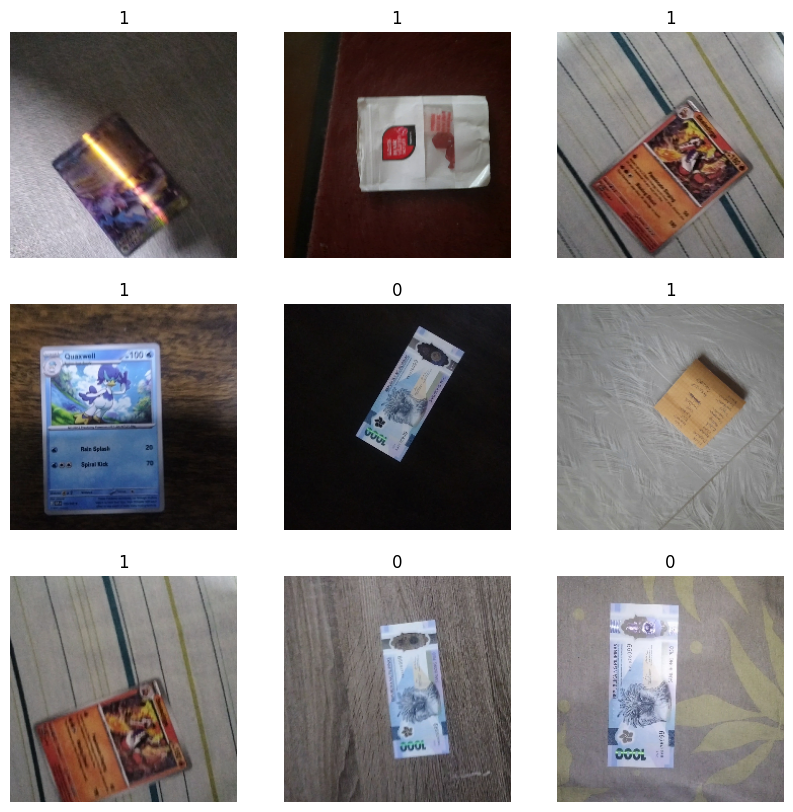

In [ ]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
overfitting.

In [ ]:
# Define data augmentation layers using Sequential for efficiency
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2), layers.RandomContrast(0.2)])

# Apply augmentation inside the dataset pipeline (more efficient)
def augment_data(images, labels):
    return data_augmentation(images), labels

# Apply augmentation only to the training dataset
train_ds = train_ds.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)


Let's visualize what the augmented samples look like, by applying `data_augmentation`
repeatedly to the first few images in the dataset:

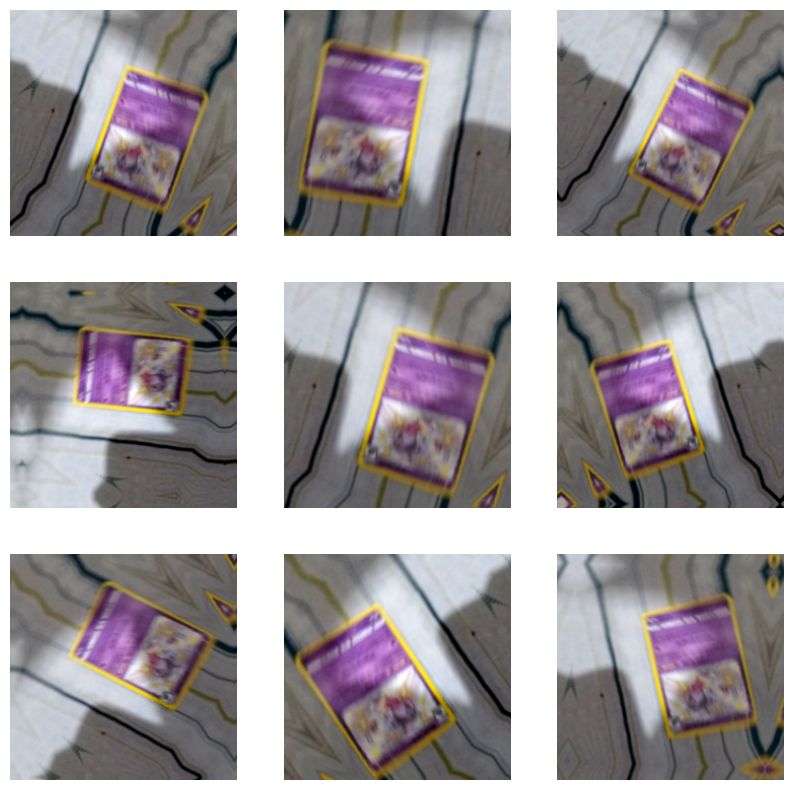

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")


## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
our model.

## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this may be a good option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
augmented images, like this:

```python
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
asynchronous and non-blocking.

In our case, we'll go with the second option. If you're not sure
which one to pick, this second option (asynchronous preprocessing) is always a solid choice.

## Configure the dataset for performance

Let's apply data augmentation to our training dataset,
and let's make sure to use buffered prefetching so we can yield data from disk without
having I/O becoming blocking:

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
configuration, consider using
[KerasTuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, Model

# Load MobileNetV2 with pre-trained weights
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

# Freeze base model to use pretrained features
base_model.trainable = False

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(1, activation="sigmoid")(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Train the model

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import keras

# Define dataset distribution
num_1000 = 5634
num_not_1000 = 5279

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=np.concatenate([
        np.full(num_1000, 0),  # Create an array of 0s (label for "1000")
        np.full(num_not_1000, 1)  # Create an array of 1s (label for "Not 1000")
    ])
)

# Convert to dictionary format
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class Weights:", class_weight_dict)

# Learning rate schedule (Exponential Decay)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-4, decay_steps=1000, decay_rate=0.9, staircase=True
)

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss", mode="min"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)  # Stop early if no improvement
]

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[keras.metrics.BinaryAccuracy(name="accuracy")],
)

# Train model with class weights
history = model.fit(
    train_ds,
    epochs=45,
    callbacks=callbacks,
    validation_data=val_ds,
    class_weight=class_weight_dict
)

# Optional: Fine-tune after initial training
base_model.trainable = True  # Unfreeze base model for fine-tuning

# Lower learning rate for fine-tuning
fine_tune_lr = keras.optimizers.Adam(learning_rate=1e-5)

# Recompile model for fine-tuning
model.compile(
    optimizer=fine_tune_lr,
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[keras.metrics.BinaryAccuracy(name="accuracy")],
)

# Continue training with unfrozen layers
history_fine_tune = model.fit(
    train_ds,
    epochs=10,  # Short fine-tuning phase
    callbacks=callbacks,
    validation_data=val_ds,
    class_weight=class_weight_dict
)


Class Weights: {0: np.float64(1.5907039711191335), 1: np.float64(0.7292097641704592)}
Epoch 1/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 871s 12s/step - accuracy: 0.5810 - loss: 0.8390 - val_accuracy: 0.5742 - val_loss: 0.8771
Epoch 2/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 864s 12s/step - accuracy: 0.8199 - loss: 0.3650 - val_accuracy: 0.6118 - val_loss: 0.9174
Epoch 3/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 857s 12s/step - accuracy: 0.8764 - loss: 0.2744 - val_accuracy: 0.6370 - val_loss: 0.8423
Epoch 4/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 884s 13s/step - accuracy: 0.9073 - loss: 0.2269 - val_accuracy: 0.6054 - val_loss: 1.0495
Epoch 5/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 860s 12s/step - accuracy: 0.9159 - loss: 0.1961 - val_accuracy: 0.6783 - val_loss: 0.7455
Epoch 6/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 861s 12s/step - accuracy: 0.9369 - loss: 0.1633 - val_accuracy: 0.6664 - val_loss: 0.8288
Epoch 7/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 863s 12s/step - accuracy: 0.9435 - loss: 0.1475 - val_accuracy: 0.6618 - val_loss: 0.9018
Epoch 8/25
69/69 ━

We get to >90% validation accuracy after training for 25 epochs on the full dataset
(in practice, you can train for 50+ epochs before validation performance starts degrading).

## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
This image is 53.55% 1000 and 46.45% Not 1000.
Classified as: 1000


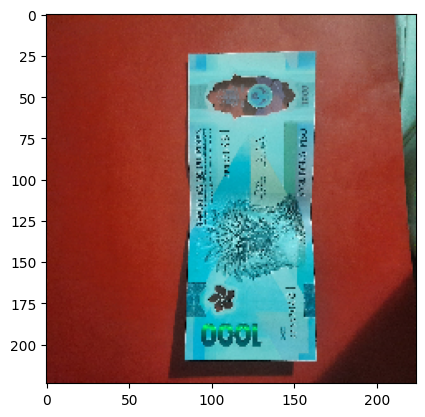

In [ ]:
import keras
import matplotlib.pyplot as plt

# Load and preprocess image
img = keras.utils.load_img("/content/test_3.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis
img_array /= 255.0  # Use 255 instead of 244 (standard scaling for images)

# Predict
predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))

# Fix probability display
print(f"This image is {100 * score:.2f}% 1000 and {100 * (1 - score):.2f}% Not 1000.")

# Fix classification decision
threshold = 0.5  # Adjust threshold if needed
label = '1000' if score > threshold else 'Not 1000'
print(f'Classified as: {label}')


In [ ]:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,750,277 (10.49 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 328,196 (1.25 MB)